X shape: (500, 447)
y shape: (500,)
Total parameters: 22551


c:\Users\saket\Downloads\Projects\Machine Learning Pipeline\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training on cpu
Epoch 1/100 - Train Loss: 34.514364, Val Loss: 31.545158
Epoch 10/100 - Train Loss: 14.677060, Val Loss: 14.178061
Epoch 20/100 - Train Loss: 9.069692, Val Loss: 8.329537
Epoch 30/100 - Train Loss: 7.290547, Val Loss: 7.611423
Epoch 40/100 - Train Loss: 7.033333, Val Loss: 7.444808
Epoch 50/100 - Train Loss: 5.771114, Val Loss: 7.702313
Epoch 60/100 - Train Loss: 4.847094, Val Loss: 7.097985
Epoch 70/100 - Train Loss: 4.714682, Val Loss: 7.242247
Epoch 80/100 - Train Loss: 4.491746, Val Loss: 6.950199
Epoch 90/100 - Train Loss: 3.668982, Val Loss: 7.971178
Epoch 100/100 - Train Loss: 3.489764, Val Loss: 6.986005


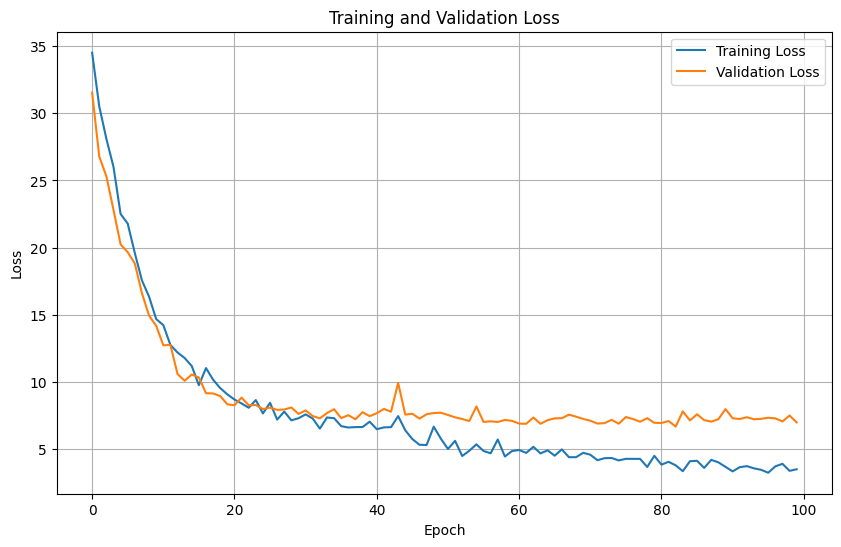


Log Scale Performance:
R² Score: -0.1453
RMSE: 3.0492
MAE: 2.3923

Original Scale Performance:
R² Score: 0.4048
RMSE: 12899.23
MAE: 3806.74


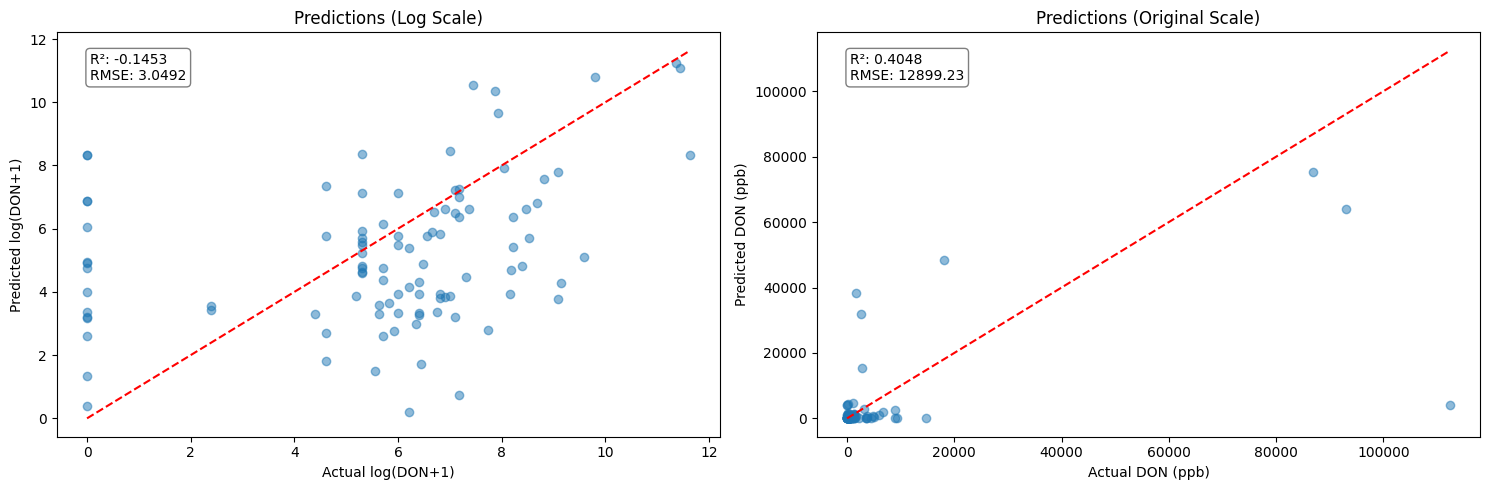

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Load data
X = pd.read_csv('X_data.csv').values
y = pd.read_csv('Y_data.csv').values.ravel()  # Assuming Y is already log-transformed

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create PyTorch datasets
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)
)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define simple neural network with specified architecture
class SimpleNN(nn.Module):
    def __init__(self, input_dim=448):
        super(SimpleNN, self).__init__()
        # Only 3 layers: 448 -> 50 -> 1
        self.fc1 = nn.Linear(input_dim, 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(50, 1)
        
        # Weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create model
model = SimpleNN(input_dim=X_train.shape[1])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
               num_epochs=100, patience=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on {device}")
    model.to(device)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        running_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Learning rate scheduling
        scheduler.step(epoch_val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {epoch_train_loss:.6f}, "
                  f"Val Loss: {epoch_val_loss:.6f}")
        
        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, train_losses, val_losses

# Train model
model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=100, patience=20
)

# Evaluation function
def evaluate_model(model, test_loader, is_log_transformed=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            y_true.extend(targets.numpy().flatten())
            outputs = model(inputs)
            y_pred.extend(outputs.cpu().numpy().flatten())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Metrics on log scale
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    print("\nLog Scale Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    # Metrics on original scale
    if is_log_transformed:
        y_true_orig = np.expm1(y_true)
        y_pred_orig = np.expm1(y_pred)
        y_pred_orig = np.maximum(y_pred_orig, 0)  # No negative predictions
        
        r2_orig = r2_score(y_true_orig, y_pred_orig)
        mse_orig = mean_squared_error(y_true_orig, y_pred_orig)
        rmse_orig = np.sqrt(mse_orig)
        mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
        
        print("\nOriginal Scale Performance:")
        print(f"R² Score: {r2_orig:.4f}")
        print(f"RMSE: {rmse_orig:.2f}")
        print(f"MAE: {mae_orig:.2f}")
        
        # Visualization
        plt.figure(figsize=(15, 5))
        
        # Log scale
        plt.subplot(1, 2, 1)
        plt.scatter(y_true, y_pred, alpha=0.5)
        min_val = min(min(y_true), min(y_pred))
        max_val = max(max(y_true), max(y_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.title('Predictions (Log Scale)')
        plt.xlabel('Actual log(DON+1)')
        plt.ylabel('Predicted log(DON+1)')
        plt.text(0.05, 0.95, f'R²: {r2:.4f}\nRMSE: {rmse:.4f}',
                transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        # Original scale
        plt.subplot(1, 2, 2)
        plt.scatter(y_true_orig, y_pred_orig, alpha=0.5)
        min_val = min(min(y_true_orig), min(y_pred_orig))
        max_val = max(max(y_true_orig), max(y_pred_orig))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.title('Predictions (Original Scale)')
        plt.xlabel('Actual DON (ppb)')
        plt.ylabel('Predicted DON (ppb)')
        plt.text(0.05, 0.95, f'R²: {r2_orig:.4f}\nRMSE: {rmse_orig:.2f}',
                transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        return {
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'r2_orig': r2_orig,
            'rmse_orig': rmse_orig,
            'mae_orig': mae_orig
        }
    else:
        # Visualization for non-log-transformed data
        plt.figure(figsize=(10, 6))
        plt.scatter(y_true, y_pred, alpha=0.5)
        min_val = min(min(y_true), min(y_pred))
        max_val = max(max(y_true), max(y_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.title('Predicted vs Actual DON')
        plt.xlabel('Actual DON')
        plt.ylabel('Predicted DON')
        plt.text(0.05, 0.95, f'R²: {r2:.4f}\nRMSE: {rmse:.2f}',
                transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        return {
            'r2': r2,
            'rmse': rmse,
            'mae': mae
        }

# Evaluate model
results = evaluate_model(model, test_loader, is_log_transformed=True)

X shape: (500, 447)
y shape: (500,)
Training samples: 320
Validation samples: 80
Test samples: 100
Total parameters: 448
Training on cpu
Epoch 1/100 - Train Loss: 8.927589, Val Loss: 5.455992
Epoch 10/100 - Train Loss: 7.967330, Val Loss: 5.296297


c:\Users\saket\Downloads\Projects\Machine Learning Pipeline\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 20/100 - Train Loss: 7.509919, Val Loss: 4.921242
Epoch 30/100 - Train Loss: 7.064335, Val Loss: 5.026133
Epoch 40/100 - Train Loss: 6.890633, Val Loss: 4.866658
Epoch 50/100 - Train Loss: 7.072821, Val Loss: 5.129560
Early stopping at epoch 59


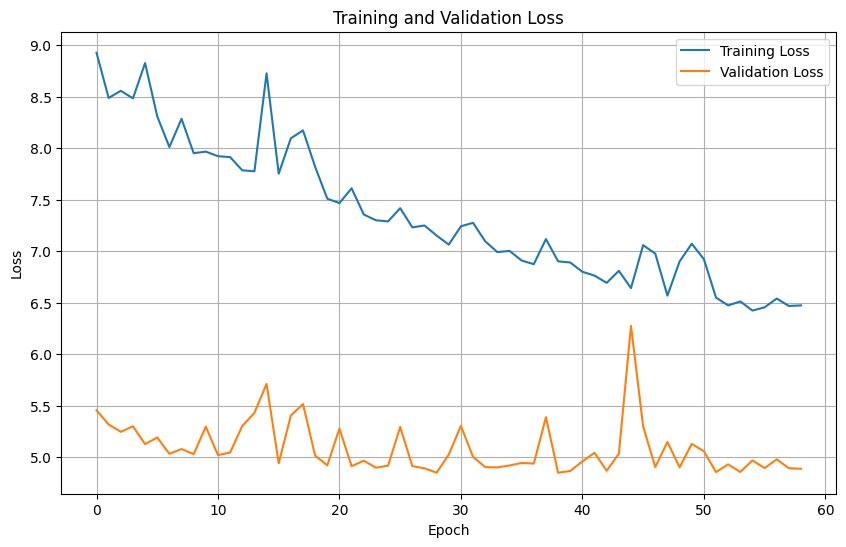


Log Scale Performance:
R² Score: 0.1374
RMSE: 2.6463
MAE: 2.0546

Original Scale Performance:
R² Score: 0.7943
RMSE: 7583.01
MAE: 2577.99


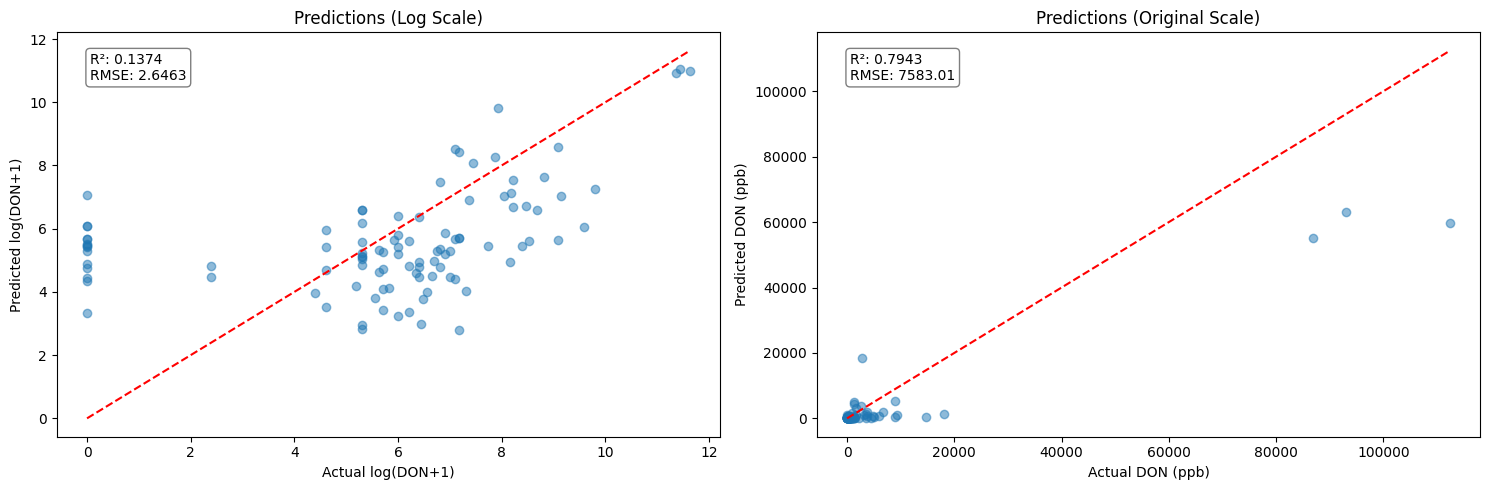

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Load data
X = pd.read_csv('X_data.csv').values
y = pd.read_csv('Y_data.csv').values.ravel()  # Assuming Y is already log-transformed

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Create PyTorch datasets
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)
)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define neural network with direct mapping and non-linearity at the end
class DirectNonLinearNN(nn.Module):
    def __init__(self, input_dim=448):
        super(DirectNonLinearNN, self).__init__()
        # A single linear layer
        self.fc = nn.Linear(input_dim, 1)
        
        # Weight initialization
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    
    def forward(self, x):
        # Apply linear transformation
        linear_output = self.fc(x)
        
        # Apply non-linearity at the end - we use Sigmoid * scale factor
        # since we're dealing with log values, we adjust the range to approximately 0-12
        # sigmoid outputs 0-1, so we scale it up to match the target range
        output_range = 12.0  # Approximate range for log(DON+1)
        
        # Apply sigmoid and scale
        # This will constrain outputs to the range [0, output_range]
        non_linear_output = torch.sigmoid(linear_output) * output_range
        
        return non_linear_output

# Create model
model = DirectNonLinearNN(input_dim=X_train.shape[1])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
               num_epochs=100, patience=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on {device}")
    model.to(device)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation
        model.eval()
        running_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Learning rate scheduling
        scheduler.step(epoch_val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {epoch_train_loss:.6f}, "
                  f"Val Loss: {epoch_val_loss:.6f}")
        
        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, train_losses, val_losses

# Train model
model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=100, patience=20
)

# Evaluation function
def evaluate_model(model, test_loader, is_log_transformed=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            y_true.extend(targets.numpy().flatten())
            outputs = model(inputs)
            y_pred.extend(outputs.cpu().numpy().flatten())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Metrics on log scale
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    print("\nLog Scale Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    # Metrics on original scale
    if is_log_transformed:
        y_true_orig = np.expm1(y_true)
        y_pred_orig = np.expm1(y_pred)
        y_pred_orig = np.maximum(y_pred_orig, 0)  # No negative predictions
        
        r2_orig = r2_score(y_true_orig, y_pred_orig)
        mse_orig = mean_squared_error(y_true_orig, y_pred_orig)
        rmse_orig = np.sqrt(mse_orig)
        mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
        
        print("\nOriginal Scale Performance:")
        print(f"R² Score: {r2_orig:.4f}")
        print(f"RMSE: {rmse_orig:.2f}")
        print(f"MAE: {mae_orig:.2f}")
        
        # Visualization
        plt.figure(figsize=(15, 5))
        
        # Log scale
        plt.subplot(1, 2, 1)
        plt.scatter(y_true, y_pred, alpha=0.5)
        min_val = min(min(y_true), min(y_pred))
        max_val = max(max(y_true), max(y_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.title('Predictions (Log Scale)')
        plt.xlabel('Actual log(DON+1)')
        plt.ylabel('Predicted log(DON+1)')
        plt.text(0.05, 0.95, f'R²: {r2:.4f}\nRMSE: {rmse:.4f}',
                transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        # Original scale
        plt.subplot(1, 2, 2)
        plt.scatter(y_true_orig, y_pred_orig, alpha=0.5)
        min_val = min(min(y_true_orig), min(y_pred_orig))
        max_val = max(max(y_true_orig), max(y_pred_orig))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.title('Predictions (Original Scale)')
        plt.xlabel('Actual DON (ppb)')
        plt.ylabel('Predicted DON (ppb)')
        plt.text(0.05, 0.95, f'R²: {r2_orig:.4f}\nRMSE: {rmse_orig:.2f}',
                transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        return {
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'r2_orig': r2_orig,
            'rmse_orig': rmse_orig,
            'mae_orig': mae_orig
        }
    else:
        # Visualization for non-log-transformed data
        plt.figure(figsize=(10, 6))
        plt.scatter(y_true, y_pred, alpha=0.5)
        min_val = min(min(y_true), min(y_pred))
        max_val = max(max(y_true), max(y_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.title('Predicted vs Actual DON')
        plt.xlabel('Actual DON')
        plt.ylabel('Predicted DON')
        plt.text(0.05, 0.95, f'R²: {r2:.4f}\nRMSE: {rmse:.2f}',
                transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        return {
            'r2': r2,
            'rmse': rmse,
            'mae': mae
        }

# Evaluate model
results = evaluate_model(model, test_loader, is_log_transformed=True)

In [3]:
import os, json
def save_model(model, scaler, output_dir="model_artifacts"):
    """
    Save the model and relevant metadata for later use in production.
    
    Args:
        model: The trained PyTorch model
        scaler: The StandardScaler used to preprocess input features
        output_dir: Directory to save model artifacts
    """
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Save the model state dictionary
    model_path = os.path.join(output_dir, "don_prediction_model.pt")
    torch.save(model.state_dict(), model_path)
    
    # 2. Save model architecture information
    model_info = {
        "input_dim": model.fc.weight.shape[1],
        "output_range": 12.0  # Make sure this matches what's in your model
    }
    
    with open(os.path.join(output_dir, "model_info.json"), "w") as f:
        json.dump(model_info, f)
    
    # 3. Save the scaler for preprocessing
    import pickle
    scaler_path = os.path.join(output_dir, "feature_scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    
    print(f"Model saved to {output_dir}")
    print(f"- Model weights: {model_path}")
    print(f"- Scaler: {scaler_path}")
    print(f"- Model info: {os.path.join(output_dir, 'model_info.json')}")

# Call the function to save your model
save_model(model, scaler)

Model saved to model_artifacts
- Model weights: model_artifacts\don_prediction_model.pt
- Scaler: model_artifacts\feature_scaler.pkl
- Model info: model_artifacts\model_info.json
